<a href="https://colab.research.google.com/github/Mikepa22/Computervision_DL/blob/main/CV_TRADITIONAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='blue'>**LABORATORIO 1. Visión computacional Tradicional y ANN´s aplicadas a problemas de clasificación de imágenes**

<font color='red'>Integrantes (Máximo 3 personas):

- <font color='red'> Santiago Aponte Marin - 2235190
- <font color='red'> Jefferson Pino - 2235917
- <font color='red'> Miguel Ángel Palomino- 2235327

Las CNN's en general se consideran buenos clasificadores, sin embargo estas soluciones tienden a ser consideradas cajas negras. Una manera de comenzar a entender los procesos que se suceden al interior de sistemas de clasificación es usar técnicas tradicionales.

La base de este tipo de clasificadores es el sistema que se use para extraer características. En clase, hemos realizado un pequeño modelo haciendo uso de herramientas básicas como : SIFT (Detector/Descriptor) , VBoW y MLP.

Siga las instrucciones (<font color='red'>resaltadas en rojo </font>), las cuales además de guiarlo, generarán en suma el puntaje final obtenido para este laboratorio.

# Librerias-Carga dataset

In [ ]:
#Para dar un orden al trabajo realizado, coloque aqui todas las librerias que van a ser usadas.
import numpy as np
import cv2
import random
import os
import math
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.spatial import distance
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from google.colab.patches import cv2_imshow
from scipy.spatial import distance
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from mlxtend.plotting import plot_learning_curves
from skimage.feature import hog
from skimage import exposure

In [ ]:
#Instalacion de kaggle (Repositorio de datasets)
!pip install kaggle

In [ ]:
#Navegacion a la carpeta content y listar arbol de archivos.
%cd /content/
!ls

/content
kaggle.json  sample_data


In [ ]:
#Se le da permisos al archivo llave kaggle.json el cual permite acceder a los repositorios de kaggle.
!chmod 600 kaggle.json

In [ ]:
#Se crea una carpeta solo para la llave a usar en kaggle.
!mkdir ~/.kaggle/

In [ ]:
#Copia del archivo kaggle a la carpeta creada anteriormente
!cp kaggle.json ~/.kaggle/
!ls

kaggle.json  sample_data


In [ ]:
#Se descarga el repositorio de reconocimiento de imagenes.
!kaggle datasets download -d tapakah68/facial-emotion-recognition

100% 432M/433M [00:07<00:00, 33.5MB/s]
100% 433M/433M [00:07<00:00, 60.2MB/s]


In [ ]:
#Se descomprime el archivo descargado
!unzip facial-emotion-recognition.zip

Archive:  facial-emotion-recognition.zip
  inflating: emotions.csv            
  inflating: images/0/Anger.jpg      
  inflating: images/0/Contempt.jpg   
  inflating: images/0/Disgust.jpg    
  inflating: images/0/Fear.jpg       
  inflating: images/0/Happy.jpg      
  inflating: images/0/Neutral.jpg    
  inflating: images/0/Sad.jpg        
  inflating: images/0/Surprised.jpg  
  inflating: images/1/Anger.jpg      
  inflating: images/1/Contempt.jpg   
  inflating: images/1/Disgust.jpg    
  inflating: images/1/Fear.jpg       
  inflating: images/1/Happy.jpg      
  inflating: images/1/Neutral.jpg    
  inflating: images/1/Sad.jpg        
  inflating: images/1/Surprised.jpg  
  inflating: images/10/Anger.jpg     
  inflating: images/10/Contempt.jpg  
  inflating: images/10/Disgust.jpg   
  inflating: images/10/Fear.jpg      
  inflating: images/10/Happy.jpg     
  inflating: images/10/Neutral.jpg   
  inflating: images/10/Sad.jpg       
  inflating: images/10/Surprised.jpg  
  inflat

<font color='red'>Punto 1 (0.5). Preprocesamiento</font>.

El pre-procesamiento de imagenes es una tarea fundamental cuando se desea que la IA trabaje correctamente.

Lea el documento que aparece en este [link](https://medium.com/spidernitt/image-preprocessing-why-is-it-necessary-8895b8b08c1d), el cual aborda este tema de una manera clara y concisa.

(a) Realice el código necesario para cumplir con la labor de pre-procesamiento del dataset dado, indicando cual o cuales técnicas utilizó y la razón que tuvo para usarlas.

(b) Realice un código que le permita mostrar nueve imagenes aleatorias seleccionadas del dataset, mostrando el antes y el despues del pre-procesamiento.


# FUNCIONES PREPROCESAMIENTO

In [ ]:
#Funcion para cargar las imagenes desde el folder y ordenarlas en un diccionario
def cargar_imagenes(folder):
  imagenes = {}
  for foldername in os.listdir(folder): #Iteral por cada folder de el dt descargado
    ruta = folder + '/' + foldername
    for filename in os.listdir(ruta): #Iteral por cada ruta nueva creada de cada folder
      if filename.endswith('.jpg'):
        emocion = filename.split('.')[0]
        img = cv2.imread(os.path.join(ruta, filename), cv2.IMREAD_GRAYSCALE) #Se convierte la imagen en escala de grises
        img= cv2.resize(img, (240, 240)) #considerar 240x240/ unico resize
        if emocion not in imagenes:
          imagenes[emocion] = []
        imagenes[emocion].append(img) #Carga de la imagen iterada.

  return imagenes

#Muestra imagenes aleatorias una por clase.
def show_images(dataset):
  i=0
  plt.figure(figsize=(15,15))
  for numero in dataset.keys(): #itera por cada llave del data set
    cantidad=len(dataset[numero])
    aleatorio=random.randint(0,cantidad-1) #crea un arreglo aleatorio para imprimir imagenes aleatorias por categoria
    plt.subplot(1,10,i+1)
    plt.imshow(dataset[numero][aleatorio],'gray')
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_title('C:'+str(numero))
    i+=1
  plt.show()


In [ ]:
#Ecualizacion del histograma
def hist_eq2(dataset):
    dataset_norm = {}
    for key, value in dataset.items():
        x = []  # Nueva lista para cada key
        for imagen in value:
            if imagen is not None:
                if len(imagen.shape) > 2:  # Convertir a grayscale solo si se requiere
                    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
                    imagen= cv2.resize(imagen, (240, 240)) #Resize de la imagen
                img = cv2.equalizeHist(imagen)
                x.append(img)
        dataset_norm[key] = x
    return dataset_norm

#funcion para crear un filtro 5 x 5
def filtro_de_mediana(dataset):
    dataset_filtrado = {}
    for key, value in dataset.items():
        filtered_images = []  # Nueva lista para cada key
        for image in value:
            if image is not None:
                filtered_image = cv2.medianBlur(image, 3)  # Aplicar filtro de mediana con un kernel de 5x5
                filtered_images.append(filtered_image)
        dataset_filtrado[key] = filtered_images
    return dataset_filtrado

#Funcion para idintificar el numero de elementos por clase en diciconario
def detect(diccionario):
  contador=[]
  print("Determinar numero de elementos por clase:")
  for items in diccionario:
    print(f'Clase:{items} Items:{len(diccionario[items])}')
    contador.append(len(diccionario[items]))
  #detectando el numero minimo de elementos
  print(f'numero minimo de elementos: {min(contador)}')


**Funciones para extraer rostros**

Consideramos que para aumentar la precision del modelo era necesario extraer la porcion de la imagen  relevante para la identificacion de las emociones, es decir, el rostro. MTCNN puede detectar y localizar con precisión rostros en imágenes, incluso en condiciones difíciles, como variaciones en la iluminación, cambios de escala y rotaciones. Se consideraron otras opciones como Haar Cascades pero el resultado no era tan bueno en comparacion con MTCNN.

In [ ]:
#Libreria para mejorar la extracion de informacion de rostros para condiciones visuales complejas.
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.9 MB/s eta 0:00:00


In [ ]:
from mtcnn import MTCNN

def crop_faces(images_dict):
    detector = MTCNN()
    cropped_images = {}

    for emotion, images in images_dict.items():
        cropped_images[emotion] = []
        for img in images:
            if len(img.shape) < 3:  # Esta en escala de grises?
                img = np.stack((img,) * 3, axis=-1)  # Convertir grayscale to RGB, MTCNN trabaja con imagenes a color
            faces = detector.detect_faces(img)
            if faces:  # Verificar si se detecta la cara
                for face in faces:
                    x, y, w, h = face['box']
                    cropped_face = img[max(0, y):y + h, max(0, x):x + w]  # Adjustar para valores negativos
                    cropped_images[emotion].append(cropped_face)
            else:
                cropped_images[emotion].append(img)  # Si no se detecta la cara se agrega la imagen original

    return cropped_images

## Preprocesamiento

In [ ]:
dataset=cargar_imagenes('images') #Cargar imagenes
detect(dataset) #Se determina el numero de elementos por clase.

Determinar numero de elementos por clase:
Clase:Surprised Items:19
Clase:Neutral Items:19
Clase:Contempt Items:19
Clase:Disgust Items:19
Clase:Sad Items:19
Clase:Fear Items:19
Clase:Anger Items:19
Clase:Happy Items:19
numero minimo de elementos: 19


In [ ]:
faces=crop_faces(dataset)# Extraer rostros

1/1 [==============================] - 0s 28ms/step


In [ ]:
detect(faces) #Deterta el numero de elementos por clase en las caras extraidas.

Determinar numero de elementos por clase:
Clase:Surprised Items:19
Clase:Neutral Items:19
Clase:Contempt Items:19
Clase:Disgust Items:19
Clase:Sad Items:19
Clase:Fear Items:19
Clase:Anger Items:19
Clase:Happy Items:19
numero minimo de elementos: 19


In [ ]:
normalizado=hist_eq2(faces) #Aplicar normalizacion del histograma

In [ ]:
filtrado=filtro_de_mediana(normalizado) #Se aplica el filtrado a la matriz normalizada

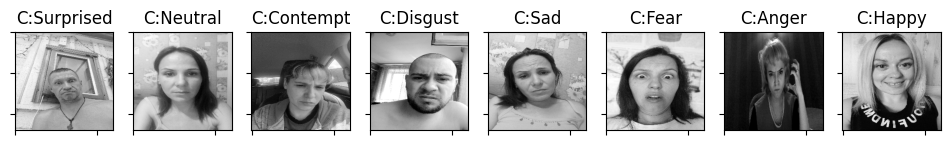

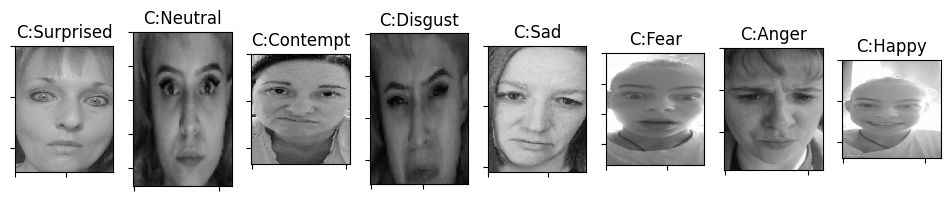

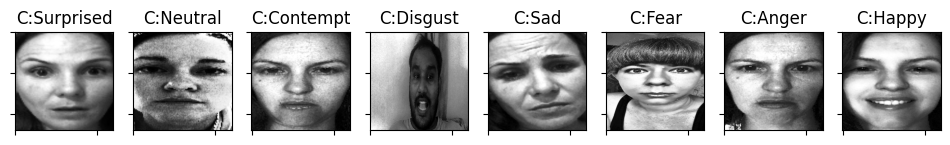

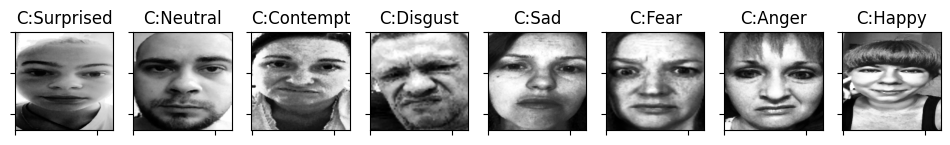

In [ ]:
#Visualiador imagenes
show_images(dataset)
show_images(faces)
show_images(normalizado)
show_images(filtrado)

In [ ]:
#Funcion para aumentar la forma y mejoramiento de imaganes para tener un datase mas amplio. Basado en el dataset actual.
def aumentacion_de_datos(diccionario_imagenes):
    diccionario_aumentado = {}
    for emocion, imagenes in diccionario_imagenes.items():
        imagenes_aumentadas = []
        for imagen in imagenes:
            if imagen is not None:
                # Aumentación de datos con cambios de brillo y contraste
                imagen_aumentada1 = np.clip(1.2 * imagen, 0, 255).astype(np.uint8)
                imagen_aumentada2 = np.clip(0.8 * imagen, 0, 255).astype(np.uint8)

                # Aumentación de datos con cambios de rotación
                (h, w) = imagen.shape[:2]
                centro = (w // 2, h // 2)
                M = cv2.getRotationMatrix2D(centro, 30, 1.0)
                imagen_aumentada3 = cv2.warpAffine(imagen, M, (w, h))

                # Aumentación de datos con cambios de escala
                imagen_aumentada4 = cv2.resize(imagen, (180, 180))

                imagenes_aumentadas.extend([imagen_aumentada1, imagen_aumentada2, imagen_aumentada3, imagen_aumentada4])

        diccionario_aumentado[emocion] = imagenes_aumentadas

    return diccionario_aumentado

In [ ]:
#final=aumentacion_de_datos(normalizado)
final=aumentacion_de_datos(normalizado) #Creacion de diccionario de datos con imagenes mejorados con un dt normalizado.
detect(final)

Determinar numero de elementos por clase:
Clase:Surprised Items:76
Clase:Neutral Items:76
Clase:Contempt Items:76
Clase:Disgust Items:76
Clase:Sad Items:76
Clase:Fear Items:76
Clase:Anger Items:76
Clase:Happy Items:76
numero minimo de elementos: 76


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba de forma aleatoria
ordenado=dict(sorted(final.items()))
train_data = {}
test_data = {}

for emotion, images_list in ordenado.items():
    random.shuffle(images_list)  # Mezclar aleatoriamente el conjunto de datos para cada emoción
    total_samples = len(images_list)
    train_size = math.ceil(total_samples * 0.8)  # Tamaño del conjunto de entrenamiento (80%)
    train_data[emotion] = images_list[:train_size]
    test_data[emotion] = images_list[train_size:]
# Verificar las longitudes de los conjuntos de entrenamiento y prueba
print("Train data lengths:", {k: len(v) for k, v in train_data.items()})
print("Test data lengths:", {k: len(v) for k, v in test_data.items()})


Train data lengths: {'Anger': 61, 'Contempt': 61, 'Disgust': 61, 'Fear': 61, 'Happy': 61, 'Neutral': 61, 'Sad': 61, 'Surprised': 61}
Test data lengths: {'Anger': 15, 'Contempt': 15, 'Disgust': 15, 'Fear': 15, 'Happy': 15, 'Neutral': 15, 'Sad': 15, 'Surprised': 15}


<font color='red'>Punto 2 (2.0). Cree un clasificador tradicional para el dataset dado, usando SIFT como Detector/Descriptor.

(1.0) Utilice los conocimientos adquiridos en clase acerca de visión computacional tradicional: detectores/descriptores, BoVW y ANN´s para que cree, entrene y valide un CLASIFICADOR TRADICIONAL.

(0.5) ¿Cómo seleccionó el numero de palabras en su diccionario? (Lea acerca de la técnica KNN y el ELBOW METHOD, para crear una función que le permita obtener el K óptimo)

(0.5) ¿Como seleccionó o creó la estrucutra de su modelo MLP? (De una explicación clara y concisa. Tenga en cuenta dentro de su explicación dar respuesta a la selección de: numero de capas, numero de neuronas por capa, función de activación, optimizador)



# CLASIFICADOR SIFT

In [ ]:
#Creacion de las features y agrupacion por categoria.
def features(imagenes):
  sift = cv2.SIFT_create()
  feat_all = []    #todas las features
  feat_category={} #features por categoria
  for key, imgs in imagenes.items():
    feat_ximg=[] #extrae las featuees por cada imagen
    for img in imgs:
      kp,desc = sift.detectAndCompute(img,None)
      if desc is not None:
         feat_all.extend(list(desc))
         feat_ximg.append(list(desc))
    feat_category[key]=feat_ximg #agrega las features por imagen en cada categoria
  return (feat_all, feat_category)

In [ ]:
#Comprobacion de los features de training y de test, incluyendo longitudes.
feat_train=features(train_data)
print("Se extrajeron {} características SIFT de 128 imágenes.".format(len(feat_train[0])))
print("Las características SIFT se dividieron en {} categorías.".format(len(feat_train[1])))

feat_test=features(test_data)
print("Se extrajeron {} características SIFT de 24 imágenes.".format(len(feat_test[0])))
print("Las características SIFT se dividieron en {} categorías.".format(len(feat_test[1])))

Se extrajeron 102200 características SIFT de 128 imágenes.
Las características SIFT se dividieron en 8 categorías.
Se extrajeron 24314 características SIFT de 24 imágenes.
Las características SIFT se dividieron en 8 categorías.


In [ ]:
descriptor_list = feat_train[0] #todos
train_bovw_feat = feat_train[1] #por categoria

In [ ]:
descriptor_list_test = feat_test[0] #todos
test_bovw_feat = feat_test[1] #por categoria

## K-MEANS / Elbow method

La inercia mide lo bien que se ha agrupado un conjunto de datos mediante K-Means. Se calcula midiendo la distancia entre cada punto de datos y su centroide, elevando esta distancia al cuadrado y sumando estos cuadrados en un conglomerado.

Un buen modelo es el que tiene una inercia baja Y un número bajo de conglomerados (K). Sin embargo, se trata de un compromiso, ya que a medida que aumenta K, disminuye la inercia.

El método del codo nos pide encuentrar el punto en el que la disminución de la inercia comienza a ralentizarse.

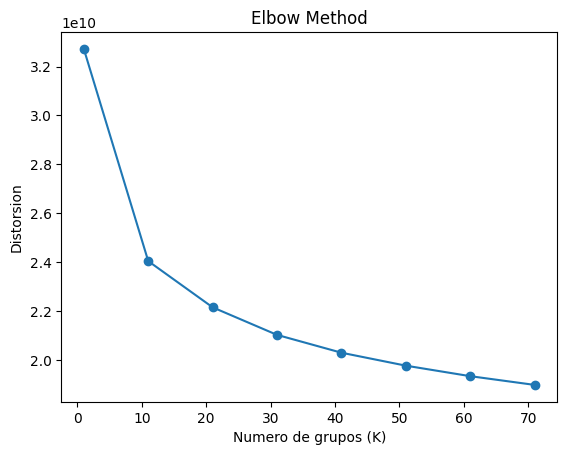

In [ ]:
#Encuentra la mejor opcion k en la lista.
def find_best_k(max_k, descriptor_list):
    distortions = []
    for i in range(1, max_k + 1,10): # establecer el rango valores de k
        km = KMeans(n_clusters=i, n_init=10)
        km.fit(descriptor_list)
        distortions.append(km.inertia_) #guardar inercia en la lista

    plt.plot(range(1, max_k + 1,10), distortions, marker='o') #Graficar k versus inercia
    plt.title('Elbow Method')
    plt.xlabel('Numero de grupos (K)')
    plt.ylabel('Distorsion')
    plt.show()


    return distortions

distortions = find_best_k(80, descriptor_list)

In [ ]:
#Cree una funcion (haciendo uos de KMeans) que le permita obtener el diccionario de palabras visuales
def kmins(k,descriptor_list):
  km= KMeans(n_clusters=k)
  km.fit(descriptor_list)
  visual_words= km.cluster_centers_

  return visual_words

In [ ]:
visual_words = kmins(500, descriptor_list)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## BOWV

In [ ]:
#Encuentra el index usando una distancia euclideana
def find_index(image, center):
  count=0
  ind = 0
  for i in range(len(center)):
    if (i==0):
      count = distance.euclidean(image, center[i])
    else:
      dist = distance.euclidean(image, center[i])
      if (dist < count):
        ind=i
        count= dist
  return ind

In [ ]:
#Funcion que permite crear un diccionario de features por cada categoria iterada.
def img_clases(bovw, centers):
  dict_feat = {}
  for key, value in bovw.items():
    categoria=[]
    for img in value:
      histo = np.zeros(len(centers))
      for  each_feature in img:
        ind = find_index(each_feature, centers)
        histo[ind] += 1
      categoria.append(histo)
    dict_feat[key]= categoria
  return dict_feat

In [ ]:
#Entrenamiento del algoritmo bovw con el diccionario de features de img_clases
bovw_train = img_clases(train_bovw_feat, visual_words)

In [ ]:
#Cree una funcion que le permita crear sus datos de manera que puedan ser usados por una red neuronal: datos + etiquetas
def preparar_datos(diccio):
  x=[] #lista de datos  (para nuestro diccionario 50)
  y=[]
  for key, values in diccio.items():
    for feat in values:
      x.append(feat)
      y.append(key)

  return np.array(x), np.array(y)

In [ ]:
#Etiqueta las emociones y genera un array por cada emocion.
def encode_emotions(emotions_array):
    emotions = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']
    emotions.sort()

    emotion_encoding = {emotions[i]: i for i in range(len(emotions))}
    encoded_array = np.array([emotion_encoding[emotion] for emotion in emotions_array])

    return encoded_array

In [ ]:
#Se preparan los datos de train para x y y
x_train, y_train=preparar_datos(bovw_train)
#y_train=encode_emotions(y_train)
print(x_train.shape)
print(y_train.shape)

(488, 500)
(488,)


In [ ]:
#Se crea el set de prueba utilizando el metodo bovw y el diccionario de palabras.
bovw_test = img_clases(test_bovw_feat, visual_words)
x_test, y_test=preparar_datos(bovw_test)
#y_test=encode_emotions(y_test)
print(x_test.shape)
print(y_test.shape)

(120, 500)
(120,)


In [ ]:
#Use la funcion StandardScaler para normalizar el dataset.
std = StandardScaler().fit(x_train)
x_train= std.transform(x_train)
x_test = std.transform(x_test)

## Clasificador

In [ ]:
#Clasificador aleatorio usando MLPClasifier
def randomized_search(X_train, y_train):
    param_dist = {
        'hidden_layer_sizes': [(128, 64), (256, 128), (512, 256), (128, 64, 32), (256, 128, 64), (512, 256, 128)],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'learning_rate_init': [0.001, 0.01, 0.1]
    }
    modelo = MLPClassifier(max_iter=1000) #Se crea el modelo o estimador
    random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    return random_search



In [ ]:
random_search_result = randomized_search(x_train, y_train)
# Mejores parámetros encontrados
print("Mejores parámetros encontrados: ", random_search_result.best_params_)
# Mejor puntuación
print("Mejor puntuación: ", random_search_result.best_score_)

Mejores parámetros encontrados:  {'solver': 'adam', 'learning_rate_init': 0.001, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (256, 128), 'alpha': 0.01, 'activation': 'relu'}
Mejor puntuación:  0.7560781640536242


In [ ]:
#Diseñe y entrene una red neuronal clásica.
#modelo = MLPClassifier((500,250), activation='relu', solver='sgd',max_iter=500)
#modelo = MLPClassifier(hidden_layer_sizes=(100), activation='tanh', solver='adam', max_iter=5000,alpha=0.01,learning_rate_init=0.001)
#modelo = MLPClassifier(hidden_layer_sizes=(500,252,126,64,32),activation= 'logistic', alpha= 0.1 ,max_iter=1000, learning_rate= 'adaptive', solver= 'sgd')
modelo = MLPClassifier(solver= 'adam', learning_rate_init= 0.001, learning_rate= 'invscaling', hidden_layer_sizes= (256, 128), alpha= 0.01, activation = 'relu')
#modelo = MLPClassifier(hidden_layer_sizes=(258,128), activation='tanh', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
modelo.fit(x_train, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(256, 128),
              learning_rate='invscaling')

In [ ]:
#Imprima el accuracy alcanzado por su modelo
prediccion = modelo.predict(x_test)
acc= accuracy_score(y_test,prediccion)
print("la exactitud de mi modelo es de {} %".format(acc*100))

la exactitud de mi modelo es de 76.66666666666667 %


In [ ]:
print(classification_report(y_test,prediccion))

              precision    recall  f1-score   support

       Anger       0.86      0.80      0.83        15
    Contempt       0.67      0.80      0.73        15
     Disgust       0.67      0.67      0.67        15
        Fear       0.79      0.73      0.76        15
       Happy       0.80      0.80      0.80        15
     Neutral       0.93      0.87      0.90        15
         Sad       0.80      0.80      0.80        15
   Surprised       0.67      0.67      0.67        15

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120



In [ ]:
#Crea la matriz de confusion
M = confusion_matrix(y_test,prediccion)
print(M)

[[12  1  1  0  0  0  1  0]
 [ 0 12  0  2  0  0  0  1]
 [ 0  2 10  1  2  0  0  0]
 [ 0  0  2 11  0  0  0  2]
 [ 0  2  0  0 12  0  1  0]
 [ 0  0  0  0  1 13  0  1]
 [ 1  0  1  0  0  0 12  1]
 [ 1  1  1  0  0  1  1 10]]


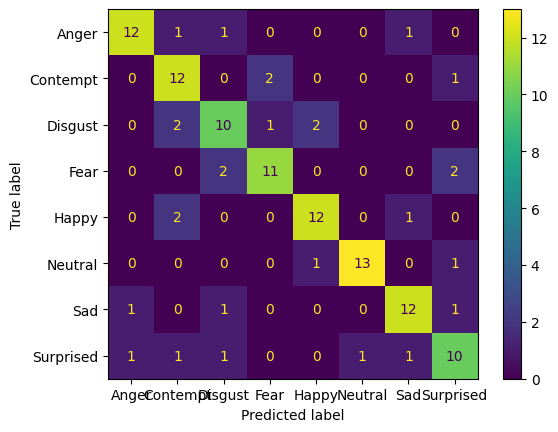

In [ ]:
#Crea la matriz de confusion y visualiza el plot de la matriz
M = confusion_matrix(y_test,prediccion,labels=modelo.classes_)
display = ConfusionMatrixDisplay(M, display_labels=modelo.classes_)
display.plot()
plt.show()

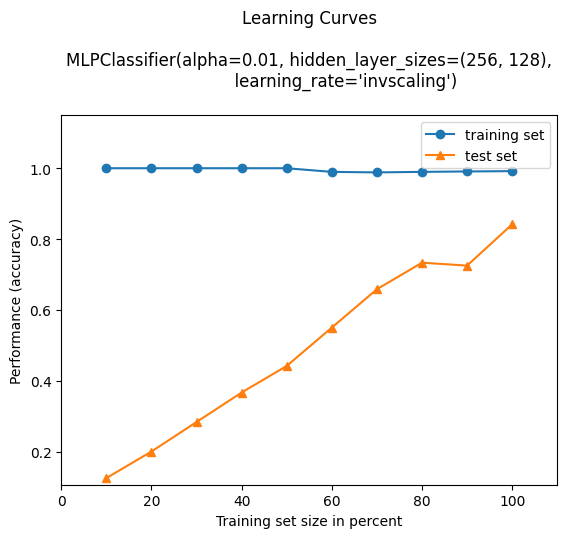

In [ ]:
#Visualice si su modelo tiene problemas de overfitting
plot_learning_curves(x_train, y_train, x_test, y_test, modelo, scoring='accuracy')
plt.show()

Para seleccionar la estructura del modelo MLP (Multilayer Perceptron), tuvimos que considerar varios factores:

- Número de capas: El número de capas puede variar según la complejidad del problema. Comenzamos con una capa  oculta como prueba, pero realmente el modelo necesitaba dos capas ocultas.

- Número de neuronas por capa: El número de neuronas en cada capa oculta depende de la complejidad del problema. Para ello experimentamos con diferentes valores y usar técnicas como búsqueda en cuadrícula o aleatorias, encontrando la mejor tecnica.

- Función de activación: Las funciones de activación comunes incluyen ReLU, Sigmoid y Tanh. Para nuestro caso utiliamos la función Tanh, siendo una buena opción para nuestro clasificador, debido a que determino la mejor manera de transformación no lineal de las entradas en cada neurona.

- Optimizador: Los optimizadores comunes incluyen SGD, Adam y RMSprop. Adam es una buena elección predeterminada, en nuestro caso utilizamos Adam debido a que se basa en el método de descenso de gradiente estocástico dandonos una mayor eficiencia y buen rendimiento en tareas de optimización

- Hiperparametros: Se utilizaron todos los hiperparametros como **alpha**, con el fin de Alpha controlar la regularización L2 en la red neuronal. La regularización L2 se utiliza para evitar el sobreajuste al penalizar los pesos grandes. Tambien el **batch_size** lo dejamos de manera automatica para que elija los lotes el mismo, el **learning_rate** lo dejamos con el valor de adaptative para controlar la tasa de aprendizaje utilizada durante el entrenamiento. 'adaptive' significa que la tasa de aprendizaje se adapta automáticamente durante el entrenamiento. el hiperparametro **learning_rate_init** establecimos una tasa de aprendizaje inicial, tambien utilizamos **power_t**  para mejorar la velocidad de adaptación de la tasa de aprendizaje cuando se utilizamos 'learning_rate="adaptive"'. Debido a que como estaba tan bajo la tasa de aprendizaje, con ello, la mejoramos, en otros casos un valor más alto hará que la tasa de aprendizaje se adapte más lentamente. **max_iter** es el número máximo de iteraciones o épocas que se realizarán durante el entrenamiento de la red, usamos el parametro **shuffle** para controlar si se deben mezclar los datos de entrenamiento en cada iteración. **random_state**  se usa para establecer una semilla para la generación de números aleatorios, tambien **tol** que es La tolerancia que indica cuándo se considera que el entrenamiento ha convergido, el hiperparametro **verbose**, Controla la cantidad de información que se muestra durante el entrenamiento. Asi mismo **warm_start** lo establecimos en false porque es el que permite continuar el entrenamiento desded un modelo previamente ajustado, tambien el momentum, que controla el termino de momento en el algoritmo de optimización, permitiendolo acelerar y superar los minimos locales. Por otro lado **nesterovs_momentum** es un parametro para habilitar el termino de momento tipo nesterov durante el entrenamiento y permite mejorar la convergencia en algunas situaciones. early_stopping es  un parametro que desactivamos para no detener el entrenamiento cuando la perdida en el conjunto de validación no mejorara durante ciertas iteraciones. **validation_fraction** Es la fracción de los datos de entrenamiento que se utilizarán como conjunto de validación si se utiliza la detención temprana, **beta_1=0.9 y beta_2=0.999** Estos parámetros son específicos del optimizador Adam. Controlan las tasas de decaimiento exponencial de los momentos del primer y segundo orden, respectivamente. **epsilon** Es un pequeño valor que se utiliza para evitar la división por cero en el optimizador Adam. **n_iter_no_change** Este parámetro determina cuántas iteraciones consecutivas se pueden permitir sin una mejora en la pérdida de validación antes de detener el entrenamiento si se utiliza early stopping. Por ultimo **max_fun** Es el número máximo de evaluaciones de función objetivo durante el entrenamiento. Puede ayudar a evitar un entrenamiento excesivamente largo.

En conclusion, La selección de la estructura del modelo MLP a menudo es un proceso de prueba y error, y se recomienda realizar experimentos y ajustar los hiperparámetros según el rendimiento en datos de validación. También puede considerar el uso de técnicas de regularización como la disminución de la velocidad de aprendizaje, la regularización L1/L2, el abandono, etc., según sea necesario.

<font color='red'>Punto 3 (1.5). Cree un clasificador tradicional para el dataset dado, usando HOG.</font>

(1.0) Lea acerca del HOG (Histogram of Gradients) y uselo como entrada a su CLASIFICADOR TRADICIONAL, sustituyendo de esta manera a SIFT.
<font color='red'> [Nota: Solo puede cambiar el vector de entrada a su modelo.]

(0.25) De una explicación corta acerca (No más de 10 líneas) de como HOG modifica el código implementado.

(0.25) Muestre una tabla comparando las metricas obtenidas. (SIFT Vs HOG). Realice un análisis de los resultados obtenidos.

# Clasificador HOG

In [ ]:
def find_idx(feat,center):
  count = 0
  ind = 0
  for i in range(len(center)):
    if (i==0):
      count = distance.euclidean(feat,center[i])
    else :
      dist=distance.euclidean(feat,center[i])
      if (dist<count):
        ind=i
        count=dist
  return ind
def preparar_datos(diccio):
  y = []
  x = []
  for key, values in diccio.items():
    for histo in values:
      x.append(histo)
      y.append(key)
  return np.array(x),np.array(y)

In [ ]:
def resize_img(dataset):
  dataset_norm={}

  for key,value in dataset.items():
    x=[]
    for imagen in value:
      img_test = cv2.resize(imagen,(64,128))

      if img_test is not None:
        x.append(img_test)
    dataset_norm[key]=x
  return dataset_norm

#---------------------------------------------------------------------------------------
#funcion para calcular los descriptores por imagen y categoria usando HOG
def features_HOG(dataset):
  hog = cv2.HOGDescriptor(_winSize=(64, 128), _blockSize=(16,32), _blockStride=(2, 4), _cellSize=(8, 16), _nbins=18)
  feat_all = []       # Todas las características
  feat_category = {}  # Características por categoría

  for category, imgs in dataset.items():
      feat_ximg = []  # Extrae las características por cada imagen
      for img in imgs:
          desc = hog.compute(img)
          if desc is not None:
              feat_all.append(list(desc))
              feat_ximg.append(list(desc))
      feat_category[category] = feat_ximg  # Agrega las características por imagen en cada categoría

  return feat_all, feat_category


#---------------------------------------------------------------------------------------
#funciona para Clusterizar utilizando el K como entrada
def clustering2(k,lista):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(lista)
  diccionario = kmeans.cluster_centers_
  return diccionario

#---------------------------------------------------------------------------------------

#funcion para calcular el histograma de la BOVW
def img_histos_hog(bovw_feat,centers):
  dict_feat={}
  for key,value in feat_train2[1].items():
    imagens=[]
    for img in value:
      histo = np.zeros(len(diccionario_vis2))

      idx = find_idx(img,diccionario_vis2)
      histo[idx]+=1
      imagens.append(histo)
    dict_feat[key]=imagens
  return dict_feat

#---------------------------------------------------------------------------------------
#funcion para calcular la distorsion usando distancia euclidaiana y hayar el k optimo
def k_opt(lista):
  distortion=[]
  K=range(1,100,5)
  for item in K:
    kmeanmodel=KMeans(n_clusters=item,max_iter=1).fit(lista)
    distortion.append(sum(np.min(cdist(lista,kmeanmodel.cluster_centers_,'euclidean'),axis=1))/len(lista))

  return distortion

In [ ]:
Train2=resize_img(train_data) #reescalado de imagenes
Test2=resize_img(test_data)

feat_train2=features_HOG(Train2) #calculo de features con HOG

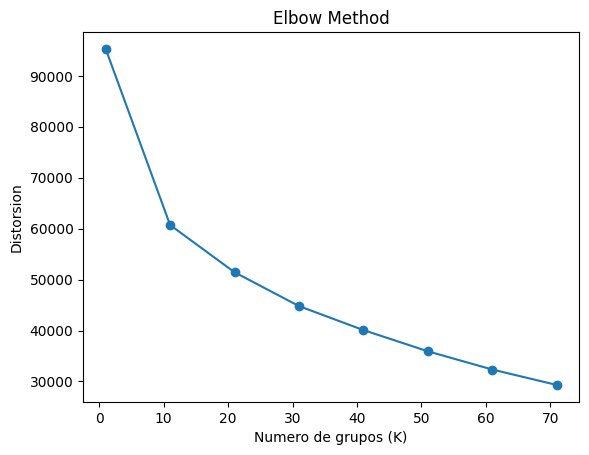

In [ ]:
def find_best_k(max_k, descriptor_list):
    distortions = []
    for i in range(1, max_k + 1,10): # establecer el rango valores de k
        km = KMeans(n_clusters=i, n_init=10)
        km.fit(descriptor_list)
        distortions.append(km.inertia_) #guardar inercia en la lista

    plt.plot(range(1, max_k + 1,10), distortions, marker='o') #Graficar k versus inercia
    plt.title('Elbow Method')
    plt.xlabel('Numero de grupos (K)')
    plt.ylabel('Distorsion')
    plt.show()


    return distortions

distortions = find_best_k(80, feat_train2[0])

In [ ]:
k=100
diccionario_vis2 = clustering2(k,feat_train2[0])

bovw_train2=img_histos_hog(feat_train2[1],diccionario_vis2) #bovw para datos de entrenamiento
x_train2,y_train2 =preparar_datos(bovw_train2) #preparacion de datos en arreglo numpy

imagenes={}
feat_test2 = features_HOG(Test2)#[1]  #calcular featrues con HOG para datos de validacion
bovw_test2=img_histos_hog(feat_test2[1],diccionario_vis2) #generar bovw datos de validacion
x_test2,y_test2=preparar_datos(bovw_test2) #preaprar datos de validacion en arreglo numpy

std = StandardScaler().fit(x_train2) #normalizacion
x_train2 = std.transform(x_train2)
x_test2 = std.transform(x_test2)



In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(258,128),activation='tanh',solver='adam', learning_rate='adaptive' )
mlp.fit(x_train2,y_train2)

MLPClassifier(activation='tanh', hidden_layer_sizes=(258, 128),
              learning_rate='adaptive')

In [ ]:
def randomized_search(X_train, y_train):
    param_dist = {
        'hidden_layer_sizes': [(128, 64), (256, 128), (512, 256), (128, 64, 32), (256, 128, 64), (512, 256, 128)],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'learning_rate_init': [0.001, 0.01, 0.1]
    }
    modelo = MLPClassifier(max_iter=500) #Se crea el modelo o estimador
    random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    return random_search

# Ejemplo de uso
random_search_result = randomized_search(x_train2, y_train2)

# Mejores parámetros encontrados
print("Mejores parámetros encontrados: ", random_search_result.best_params_)

# Mejor puntuación
print("Mejor puntuación: ", random_search_result.best_score_)

Mejores parámetros encontrados:  {'solver': 'sgd', 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (512, 256, 128), 'alpha': 0.01, 'activation': 'tanh'}
Mejor puntuación:  0.3606377338483678


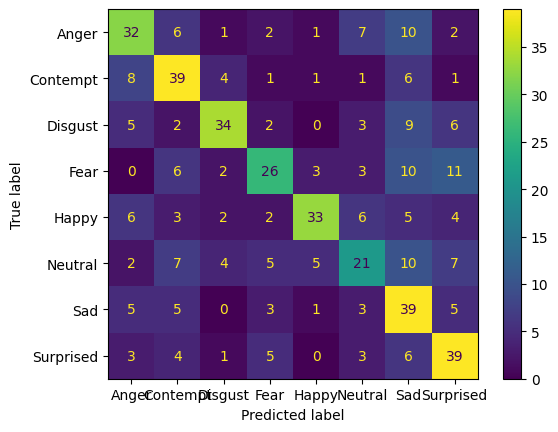


---------------------------------

              precision    recall  f1-score   support

       Anger       0.52      0.52      0.52        61
    Contempt       0.54      0.64      0.59        61
     Disgust       0.71      0.56      0.62        61
        Fear       0.57      0.43      0.49        61
       Happy       0.75      0.54      0.63        61
     Neutral       0.45      0.34      0.39        61
         Sad       0.41      0.64      0.50        61
   Surprised       0.52      0.64      0.57        61

    accuracy                           0.54       488
   macro avg       0.56      0.54      0.54       488
weighted avg       0.56      0.54      0.54       488



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
predict= mlp.predict(x_test2)
precision, recall, f_score, support = precision_recall_fscore_support(y_test2, predict, zero_division=1)

cm  =confusion_matrix(y_test2,predict,labels=mlp.classes_)


disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=mlp.classes_)
disp.plot()
plt.show()
print("\n---------------------------------\n")
print(classification_report(y_test2,predict,zero_division=1))

### Tabla comparativa (SIFT vs HOG)



<!DOCTYPE html>
<html>
<head>
<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 60%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

th {
  background-color: #f2f2f2;
}
</style>
</head>
<body>

<h2>Comparación entre Clasificador SIFT y Clasificador HOG</h2>

<table>
  <tr>
    <th>Métrica</th>
    <th>Clasificador SIFT</th>
    <th>Clasificador HOG</th>
  </tr>
  <!-- Fila de Accuracy -->
  <tr>
    <td>Accuracy</td>
    <td>0.77</td>
    <td>0.54</td>
  </tr>


</table>
</body>
</html>


HOG Modifica el codigo respecto a sift con las siguientes diferencias:
-  Se enfoca en la forma y la textura de los objetos en una imagen. Describe la distribución de gradientes de intensidad en una imagen, lo que permite capturar información sobre los bordes y las texturas.
- No es inherentemente invariante a la escala. Para lograr invariancia a la escala, se deben aplicar técnicas adicionales, como la pirámide de imágenes.
- No es inherentemente invariante a la rotación. La descripción HOG captura la orientación de los gradientes, pero no garantiza la invariancia a la rotación
- Es parcialmente robusto ante cambios en la iluminación, ya que se basa en la orientación de gradientes y no en los valores de intensidad absolutos.
- Proporciona información sobre la textura y forma general de los objetos, pero no sobre puntos de interés específicos.

En resumen, HOG se centra en la forma y la textura general de los objetos, mientras que SIFT se especializa en la detección y descripción de puntos clave invariables a la escala y la rotación.


# PUNTO 4

<font color='red'>Punto 4 (1.0). Pruebas adicionales de su mejor Clasificador</font>.

Tome un conjunto de 20 imagenes (use camaras monoculares convencionales), mostrando diferentes expresiones facilaes. Realice un programa que permita leer las imagenes, pre-procesarlas y dejarlas listas para servir de entrada a su mejor clasificador.  Muestre las imagenes procesadas y el valor de predicción de su red con porcentaje.

In [ ]:
!rm -r images #Solo utilizar si ya hay un dataset puesto

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import shutil
shutil.copytree("/content/drive/My Drive/Imagenes punto 4", "/content/Prueba")

'/content/Prueba'

In [ ]:
def cargar_imagenes_punto4():
    imagenes = {}
    folder = 'Prueba'
    for foldername in os.listdir(folder):
        ruta = os.path.join(folder, foldername)
        if os.path.isdir(ruta):
            for filename in os.listdir(ruta):
                if filename.endswith('.jpg'):
                    img = cv2.imread(os.path.join(ruta, filename), cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (256, 256))
                    if foldername not in imagenes:
                        imagenes[foldername] = []
                    imagenes[foldername].append(img)

    return imagenes

def show_images_punto4(dataset):
  i=0
  plt.figure(figsize=(15,15))
  for numero in dataset.keys():
    cantidad=len(dataset[numero])
    aleatorio=random.randint(0,cantidad-1) #crea un arreglo aleatorio para imprimir imagenes aleatorias por categoria
    plt.subplot(1,10,i+1)
    plt.imshow(dataset[numero][aleatorio],'gray')
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    #plt.gca().set_title('Clase: '+str(i))
    plt.gca().set_title('Clase: '+str(numero))
    i+=1
  plt.show()

In [ ]:
def hist_eq2_punto4(dataset):
    dataset_norm = {}
    for key, value in dataset.items():
        x = []  # Nueva lista para cada key
        for imagen in value:
            if imagen is not None:
                if len(imagen.shape) > 2:  # Convert to grayscale if the image is not already in grayscale
                    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
                    imagen= cv2.resize(imagen, (128, 128))
                img = cv2.equalizeHist(imagen)
                x.append(img)
        dataset_norm[key] = x
    return dataset_norm

def detect_punto4(diccionario):
    contador = []
    print("Determinar número de elementos por clase:")
    for clase, imagenes in diccionario.items():
        print(f'Clase: {clase} - Items: {len(imagenes)}')
        contador.append(len(imagenes))
    # Detectar el número mínimo de elementos
    print(f'Número mínimo de elementos: {min(contador)}')


In [ ]:
dataset4=cargar_imagenes_punto4()
detect_punto4(dataset4)

Determinar número de elementos por clase:
Clase: Sad - Items: 4
Clase: Disgust - Items: 3
Clase: Happy - Items: 3
Clase: Fear - Items: 3
Clase: Surprise - Items: 3
Clase: Neutral - Items: 4
Clase: Angry - Items: 3
Número mínimo de elementos: 3


In [ ]:
faces4=crop_faces(dataset4)

1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 96ms/step


In [ ]:
normalizado4=hist_eq2_punto4(faces4)
detect_punto4(normalizado4)

Determinar número de elementos por clase:
Clase: Sad - Items: 4
Clase: Disgust - Items: 3
Clase: Happy - Items: 3
Clase: Fear - Items: 3
Clase: Surprise - Items: 3
Clase: Neutral - Items: 4
Clase: Angry - Items: 3
Número mínimo de elementos: 3


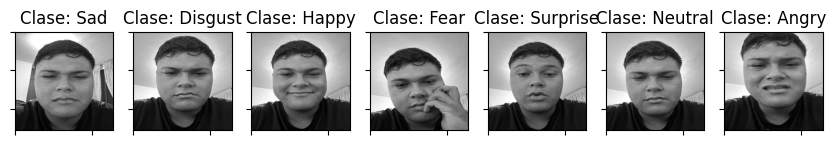

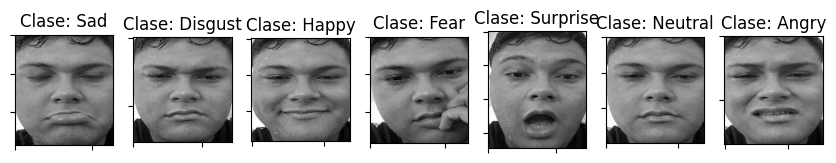

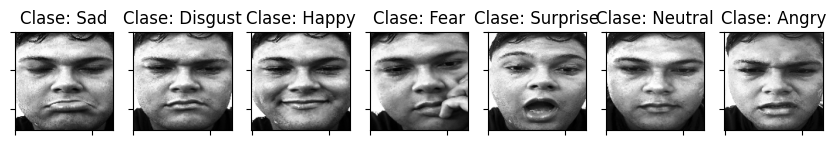

In [ ]:
#Visualizacion de las imagenes para cada uno de los data set con sus clases como labels.
show_images_punto4(dataset4)
show_images_punto4(faces4)
show_images_punto4(normalizado4)


In [ ]:
print("Train data lengths:", {k: len(v) for k, v in normalizado4.items()})


Train data lengths: {'Sad': 4, 'Disgust': 3, 'Happy': 3, 'Fear': 3, 'Surprise': 3, 'Neutral': 4, 'Angry': 3}


In [ ]:
#Funcion para crear caracteristicas para cada imagene usando SIFTe
def features(imagenes):
  sift = cv2.SIFT_create()
  feat_all = []    #todas las features
  feat_category={} #features por categoria
  for key, imgs in imagenes.items():
    feat_ximg=[] #extrae las featuees por cada imagen
    for img in imgs:
      kp,desc = sift.detectAndCompute(img,None)
      if desc is not None:
         feat_all.extend(list(desc))
         feat_ximg.append(list(desc))
    feat_category[key]=feat_ximg #agrega las features por imagen en cada categoria
  return (feat_all, feat_category)

In [ ]:
#Se crean las caracteristicas para entrenamiento y prueba de cada set de datos SIFT y se verifica su longitud.
feat_test4=features(normalizado4)
print("Se extrajeron {} características SIFT de las imágenes para test.".format(len(feat_test[0])))
print("Las características SIFT se dividieron en {} categorías para test.".format(len(feat_test[1])))

Se extrajeron 24314 características SIFT de las imágenes para test.
Las características SIFT se dividieron en 8 categorías para test.


In [ ]:
descriptor_list_test4 = feat_test4[0] #todos
test_bovw_feat4 = feat_test4[1] #por categoria

In [ ]:
#Funcion para encontrar el mejor Keypoint
def find_best_k(max_k, descriptor_list):
    distortions = []
    for i in range(1, max_k + 1,10):
        km = KMeans(n_clusters=i)
        km.fit(descriptor_list)
        distortions.append(km.inertia_)

    plt.plot(range(1, max_k + 1,10), distortions, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Numero de grupos (K)')
    plt.ylabel('Distorsion')
    plt.show()

    return distortions

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

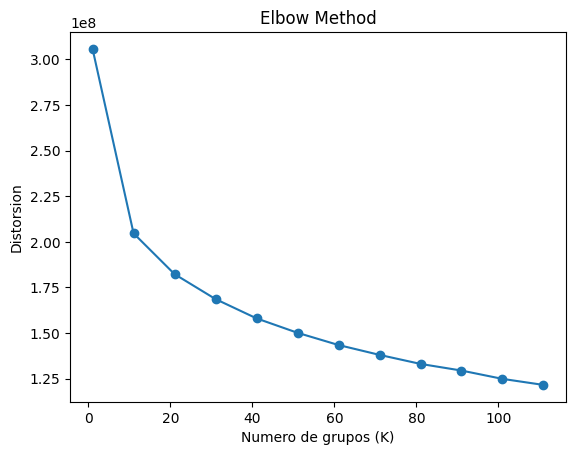

In [ ]:
#Encuentra el mejor Keypoint
distortions = find_best_k(80, descriptor_list)

In [ ]:
#Cree una funcion (haciendo uos de KMeans) que le permita obtener el diccionario de palabras visuales
def kmins(k,descriptor_list):
  km= KMeans(n_clusters=k)
  km.fit(descriptor_list)
  visual_words= km.cluster_centers_

  return visual_words

In [ ]:
#Creacion de diccionario de palabras visuales.
visual_words4 = kmins(500, descriptor_list_test4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
#Encuentra un index de una imagen basado en la distancia euclideana.
def find_index(image, center):
  count=0
  ind = 0
  for i in range(len(center)):
    if (i==0):
      count = distance.euclidean(image, center[i])
    else:
      dist = distance.euclidean(image, center[i])
      if (dist < count):
        ind=i
        count= dist
  return ind

In [ ]:
#Crea un diccionario de caracteristicas con los datos de bovw.
def img_clases(bovw, centers):
  dict_feat = {}
  for key, value in bovw.items():
    categoria=[]
    for img in value:
      histo = np.zeros(len(centers))
      for  each_feature in img:
        ind = find_index(each_feature, centers)
        histo[ind] += 1
      categoria.append(histo)
    dict_feat[key]= categoria
  return dict_feat

In [ ]:
#Crea un set de datos utilizando los datos de entrenamiento y las palabras.
bovw_train4 = img_clases(test_bovw_feat4, visual_words4)

In [ ]:
#Cree una funcion que le permita crear sus datos de manera que puedan ser usados por una red neuronal: datos + etiquetas
def preparar_datos(diccio):
  x=[] #lista de datos  (para nuestro diccionario 50)
  y=[]
  for key, values in diccio.items():
    for feat in values:
      x.append(feat)
      y.append(key)

  return np.array(x), np.array(y)

In [ ]:
#Prepara y sepra los datos para el entrenamiento
x_test4, y_test4=preparar_datos(bovw_train4)
print(x_test4.shape)
print(y_test4.shape)

(23, 500)
(23,)


In [ ]:
#Use la funcion StandardScaler para normalizar el dataset.
std = StandardScaler().fit(x_test4)
x_test4= std.transform(x_test4)
#x_test = std.transform(x_test)

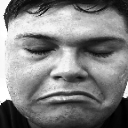

Emoción Real: Sad
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 1.90%
  - Clase Contempt: 8.57%
  - Clase Disgust: 13.59%
  - Clase Fear: 19.14%
  - Clase Happy: 26.29%
  - Clase Neutral: 0.19%
  - Clase Sad: 14.19%
  - Clase Surprised: 16.12%


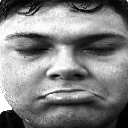

Emoción Real: Sad
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 11.37%
  - Clase Contempt: 19.99%
  - Clase Disgust: 0.41%
  - Clase Fear: 28.02%
  - Clase Happy: 23.09%
  - Clase Neutral: 12.20%
  - Clase Sad: 0.49%
  - Clase Surprised: 4.43%


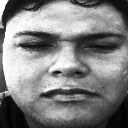

Emoción Real: Sad
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 1.12%
  - Clase Contempt: 3.23%
  - Clase Disgust: 47.85%
  - Clase Fear: 35.14%
  - Clase Happy: 0.85%
  - Clase Neutral: 2.27%
  - Clase Sad: 0.24%
  - Clase Surprised: 9.30%


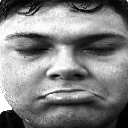

Emoción Real: Sad
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 11.37%
  - Clase Contempt: 19.99%
  - Clase Disgust: 0.41%
  - Clase Fear: 28.02%
  - Clase Happy: 23.09%
  - Clase Neutral: 12.20%
  - Clase Sad: 0.49%
  - Clase Surprised: 4.43%


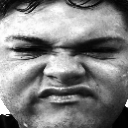

Emoción Real: Disgust
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 0.21%
  - Clase Contempt: 6.69%
  - Clase Disgust: 2.41%
  - Clase Fear: 64.68%
  - Clase Happy: 8.57%
  - Clase Neutral: 12.75%
  - Clase Sad: 4.27%
  - Clase Surprised: 0.41%


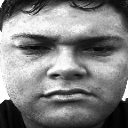

Emoción Real: Disgust
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 8.99%
  - Clase Contempt: 18.20%
  - Clase Disgust: 27.91%
  - Clase Fear: 1.44%
  - Clase Happy: 27.04%
  - Clase Neutral: 7.90%
  - Clase Sad: 6.10%
  - Clase Surprised: 2.41%


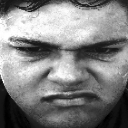

Emoción Real: Disgust
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 0.78%
  - Clase Contempt: 1.42%
  - Clase Disgust: 0.41%
  - Clase Fear: 0.93%
  - Clase Happy: 0.07%
  - Clase Neutral: 0.01%
  - Clase Sad: 95.67%
  - Clase Surprised: 0.71%


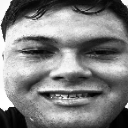

Emoción Real: Happy
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 10.64%
  - Clase Contempt: 1.55%
  - Clase Disgust: 0.57%
  - Clase Fear: 4.51%
  - Clase Happy: 65.84%
  - Clase Neutral: 2.99%
  - Clase Sad: 5.86%
  - Clase Surprised: 8.05%


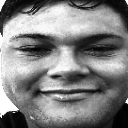

Emoción Real: Happy
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 15.92%
  - Clase Contempt: 1.18%
  - Clase Disgust: 0.00%
  - Clase Fear: 0.02%
  - Clase Happy: 9.24%
  - Clase Neutral: 0.29%
  - Clase Sad: 70.86%
  - Clase Surprised: 2.48%


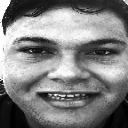

Emoción Real: Happy
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 0.24%
  - Clase Contempt: 0.29%
  - Clase Disgust: 5.88%
  - Clase Fear: 0.13%
  - Clase Happy: 0.59%
  - Clase Neutral: 42.15%
  - Clase Sad: 1.62%
  - Clase Surprised: 49.11%


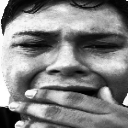

Emoción Real: Fear
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 0.78%
  - Clase Contempt: 0.17%
  - Clase Disgust: 8.23%
  - Clase Fear: 88.22%
  - Clase Happy: 2.18%
  - Clase Neutral: 0.05%
  - Clase Sad: 0.29%
  - Clase Surprised: 0.08%


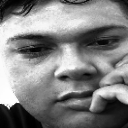

Emoción Real: Fear
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 4.69%
  - Clase Contempt: 4.84%
  - Clase Disgust: 17.13%
  - Clase Fear: 60.28%
  - Clase Happy: 0.06%
  - Clase Neutral: 4.33%
  - Clase Sad: 0.59%
  - Clase Surprised: 8.08%


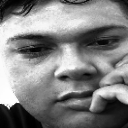

Emoción Real: Fear
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 4.69%
  - Clase Contempt: 4.84%
  - Clase Disgust: 17.13%
  - Clase Fear: 60.28%
  - Clase Happy: 0.06%
  - Clase Neutral: 4.33%
  - Clase Sad: 0.59%
  - Clase Surprised: 8.08%


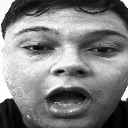

Emoción Real: Surprise
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 0.08%
  - Clase Contempt: 4.58%
  - Clase Disgust: 18.09%
  - Clase Fear: 1.89%
  - Clase Happy: 4.30%
  - Clase Neutral: 69.13%
  - Clase Sad: 1.06%
  - Clase Surprised: 0.86%


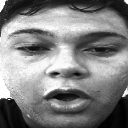

Emoción Real: Surprise
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 26.07%
  - Clase Contempt: 16.30%
  - Clase Disgust: 0.34%
  - Clase Fear: 1.12%
  - Clase Happy: 3.10%
  - Clase Neutral: 22.25%
  - Clase Sad: 30.10%
  - Clase Surprised: 0.72%


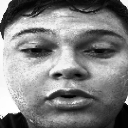

Emoción Real: Surprise
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 15.24%
  - Clase Contempt: 23.06%
  - Clase Disgust: 21.70%
  - Clase Fear: 0.71%
  - Clase Happy: 1.85%
  - Clase Neutral: 0.71%
  - Clase Sad: 3.30%
  - Clase Surprised: 33.42%


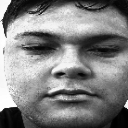

Emoción Real: Neutral
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 8.73%
  - Clase Contempt: 39.96%
  - Clase Disgust: 1.09%
  - Clase Fear: 9.62%
  - Clase Happy: 13.59%
  - Clase Neutral: 5.76%
  - Clase Sad: 9.52%
  - Clase Surprised: 11.72%


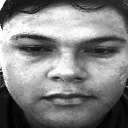

Emoción Real: Neutral
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 5.31%
  - Clase Contempt: 80.39%
  - Clase Disgust: 1.91%
  - Clase Fear: 4.39%
  - Clase Happy: 0.08%
  - Clase Neutral: 0.24%
  - Clase Sad: 1.29%
  - Clase Surprised: 6.39%


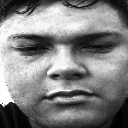

Emoción Real: Neutral
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 2.37%
  - Clase Contempt: 5.14%
  - Clase Disgust: 0.53%
  - Clase Fear: 52.42%
  - Clase Happy: 31.92%
  - Clase Neutral: 0.90%
  - Clase Sad: 4.02%
  - Clase Surprised: 2.70%


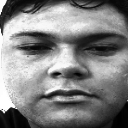

Emoción Real: Neutral
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 1.01%
  - Clase Contempt: 16.39%
  - Clase Disgust: 3.42%
  - Clase Fear: 0.49%
  - Clase Happy: 3.86%
  - Clase Neutral: 0.63%
  - Clase Sad: 13.43%
  - Clase Surprised: 60.77%


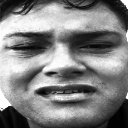

Emoción Real: Angry
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 45.36%
  - Clase Contempt: 3.80%
  - Clase Disgust: 2.28%
  - Clase Fear: 3.58%
  - Clase Happy: 33.26%
  - Clase Neutral: 5.67%
  - Clase Sad: 5.57%
  - Clase Surprised: 0.48%


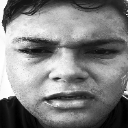

Emoción Real: Angry
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 5.33%
  - Clase Contempt: 4.03%
  - Clase Disgust: 6.05%
  - Clase Fear: 3.79%
  - Clase Happy: 7.31%
  - Clase Neutral: 1.51%
  - Clase Sad: 62.91%
  - Clase Surprised: 9.07%


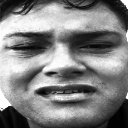

Emoción Real: Angry
Probabilidades de pertenencia a la clase predicha:
  - Clase Anger: 45.36%
  - Clase Contempt: 3.80%
  - Clase Disgust: 2.28%
  - Clase Fear: 3.58%
  - Clase Happy: 33.26%
  - Clase Neutral: 5.67%
  - Clase Sad: 5.57%
  - Clase Surprised: 0.48%


In [ ]:
nombres_clases = modelo.classes_
i = 0

for emocion, lista_imagenes in normalizado4.items():
    for imagen in lista_imagenes:
        # Mostrar la imagen
        cv2_imshow(imagen)

        # Predecir probabilidades de pertenencia a cada clase
        probabilidades = modelo.predict_proba(x_test4[[0+i]])


        # Imprimir la clase real
        print(f"Emoción Real: {emocion}")

        # Imprimir las probabilidades de pertenencia a la clase predicha
        print("Probabilidades de pertenencia a la clase predicha:")
        for j, prob in enumerate(probabilidades[0]):
            clase = nombres_clases[j]
            print(f"  - Clase {clase}: {prob:.2%}")

        i = i + 1
        # Esperar hasta que se presione una tecla para mostrar la siguiente imagen
        cv2.waitKey(0)